In [125]:
from IPython.display import display
import IPython
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn as skl
%matplotlib notebook
%matplotlib inline
import tensorflow as tf
!pip install mglearn
!pip install gensim
!pip install nltk
import nltk
import mglearn as mglearn
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

# Multilayer NN Basic Structure

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
os.chdir("/gdrive/My Drive/Colab Notebooks/Bottom Deeplearning/deep-learning-from-scratch-master/common")

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
os.chdir("/gdrive/My Drive/Colab Notebooks/Bottom Deeplearning/deep-learning-from-scratch-master/common")

from collections import OrderedDict
from layers import *
from gradient import numerical_gradient


class MultiLayerNet:
    """완전연결 다층 신경망

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）그럼 은닉층이 3개가 되는거지
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        
        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """기울기를 구한다(수치 미분).
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)
os.chdir("/gdrive/My Drive/Colab Notebooks/Bottom Deeplearning/deep-learning-from-scratch-master/ch04")
from two_layer_net import TwoLayerNet




In [ ]:
os.chdir("/gdrive/My Drive/Colab Notebooks/Bottom Deeplearning/deep-learning-from-scratch-master")
from dataset import mnist

In [ ]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.05

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size) #훈련 사이즈 중에서 배치사이즈만큼의 원소 리스트를 뽑겠다.
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if ((i+1) % iter_per_epoch) == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("{0}th Iteration : Trn_acc ={1},Test_acc={2}".format(i+1,train_acc, test_acc))

600th Iteration : Trn_acc =0.56605,Test_acc=0.5689
1200th Iteration : Trn_acc =0.79155,Test_acc=0.799
1800th Iteration : Trn_acc =0.8483666666666667,Test_acc=0.8558
2400th Iteration : Trn_acc =0.8773333333333333,Test_acc=0.8822
3000th Iteration : Trn_acc =0.8910833333333333,Test_acc=0.8947
3600th Iteration : Trn_acc =0.8975666666666666,Test_acc=0.9032
4200th Iteration : Trn_acc =0.9035166666666666,Test_acc=0.9095
4800th Iteration : Trn_acc =0.9071,Test_acc=0.9099
5400th Iteration : Trn_acc =0.9124166666666667,Test_acc=0.9153
6000th Iteration : Trn_acc =0.9147833333333333,Test_acc=0.918
6600th Iteration : Trn_acc =0.91785,Test_acc=0.9211
7200th Iteration : Trn_acc =0.9206333333333333,Test_acc=0.9233
7800th Iteration : Trn_acc =0.9227166666666666,Test_acc=0.9254
8400th Iteration : Trn_acc =0.9241,Test_acc=0.9264
9000th Iteration : Trn_acc =0.9255666666666666,Test_acc=0.9285
9600th Iteration : Trn_acc =0.928,Test_acc=0.9292


# Optimizer

In [ ]:
class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 


class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val) #val와 같은 형태의 0배열 만들기
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]


class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. (http://newsight.tistory.com/224)
    
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]


class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

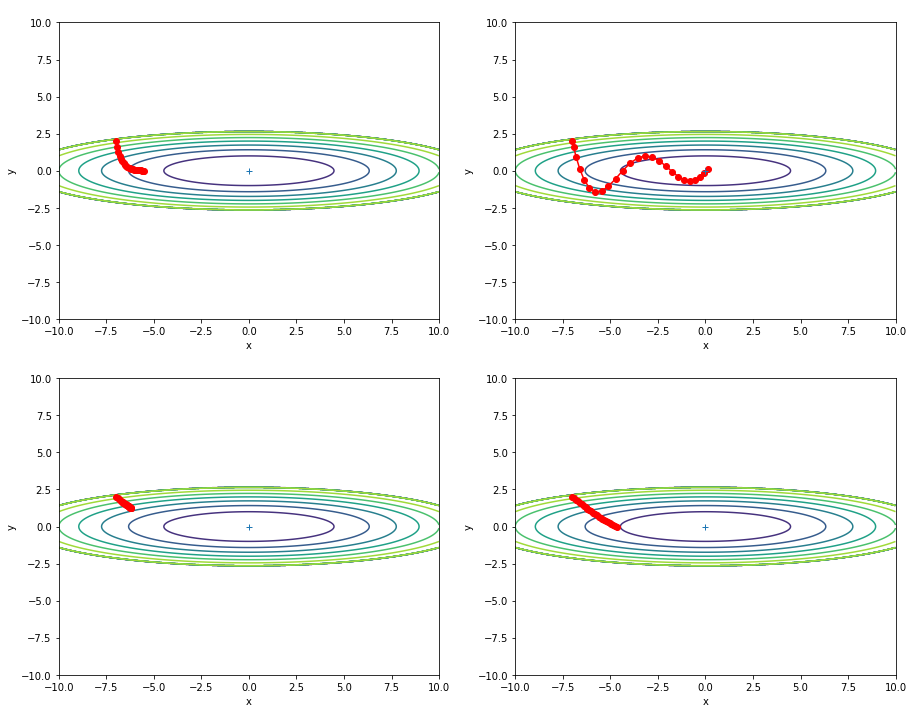

In [ ]:
from collections import OrderedDict


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.1)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=0.1)
optimizers["Adam"] = Adam(lr=0.1)

idx = 1

plt.figure(figsize=(15,12))

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(25):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z) #등고선
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key, color='white')
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

learning rate를 모두 동일하게 했을 때 Adam이 제일 적당하게 가는 듯 해
속도가 제일 빠른게 momentum 이고


# Mnist 데이터를 통한 optimization 기법 비교

In [ ]:
from dataset.mnist import load_mnist
os.chdir("/gdrive/My Drive/Colab Notebooks/Bottom Deeplearning/deep-learning-from-scratch-master/common")
from util import smooth_curve
from multi_layer_net import MultiLayerNet  
import optimizer
os.chdir("/gdrive/My Drive/Colab Notebooks/Bottom Deeplearning/deep-learning-from-scratch-master/dataset")
from dataset import mnist


In [ ]:
# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 100
max_iterations = 2000
iter_per_epoch = max(train_size / batch_size, 1)

# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD(lr=0.01)
optimizers['Momentum'] = Momentum(lr=0.0011, momentum=0.9)
optimizers['AdaGrad'] = AdaGrad(lr=0.01)
optimizers['Adam'] = Adam(lr=0.001, beta1=0.9, beta2=0.999)
optimizers['RMSprop'] = RMSprop(lr=0.01, decay_rate = 0.99)

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if ((i+1) % iter_per_epoch) == 0:
        print( "===========" + "iteration:" + str(i+1) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))




===========iteration:599===========
SGD:0.4148316583088322
Momentum:0.39195484185231527
AdaGrad:0.087737161616161
Adam:0.17733879490520438
RMSprop:0.16316324393786175
===========iteration:1199===========
SGD:0.2723136523579829
Momentum:0.2725713496116152
AdaGrad:0.0191249826836649
Adam:0.03795829591845833
RMSprop:0.1908510045029347
===========iteration:1799===========
SGD:0.28580213702743673
Momentum:0.33237134758343523
AdaGrad:0.07090252629323734
Adam:0.10207192063435741
RMSprop:0.08877528894141692


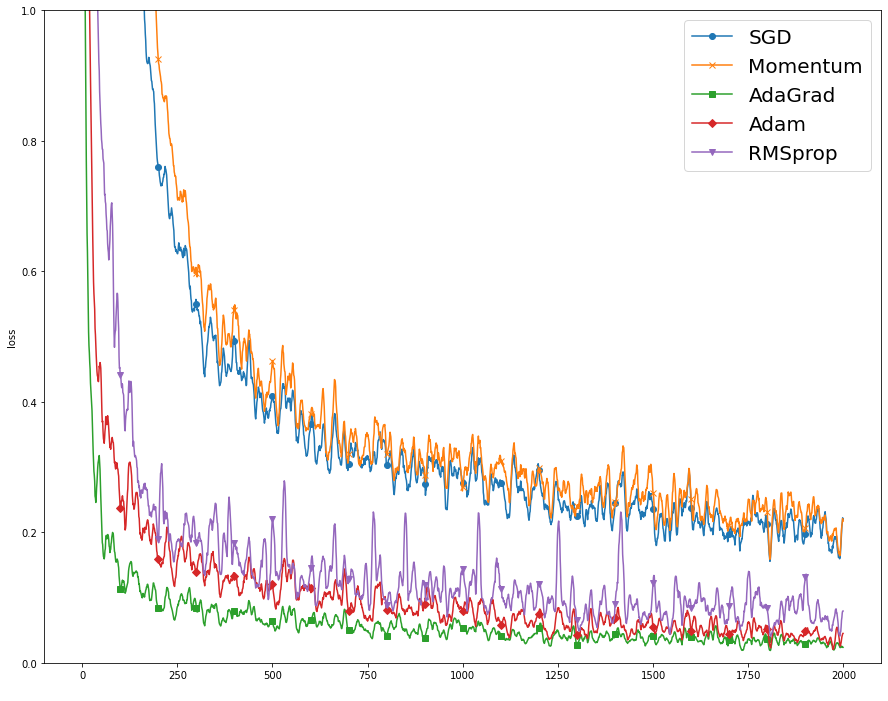

In [ ]:
# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D","RMSprop":"v"}
x = np.arange(max_iterations)
plt.figure(figsize=(15,12))
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations",color='white',fontsize=10)
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend(fontsize=20
           )
plt.show()

# Weight Initialization

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    



In [165]:
np.random.seed(0)    

input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
  # 이곳에 활성화 결과를 저장
activ_results={"a1":{},"a2":{},"a3":{},"a4":{}}
x = input_data

weight={"w1" : np.random.randn(node_num, node_num) * 1,"w2":np.random.randn(node_num, node_num) * 0.01, 
   "w3":np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
   ,"w4":np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)}

print(activ_results['a1'].values())

dict_values([])


In [174]:
for key,a in zip(weight.keys(),activ_results.keys()):
  for i in range(hidden_layer_size):
    if i != 0:
        x = activ_results[a][i-1] #결과 값을 다시 input으로 써야 하니깐

    w = weight[key]
    y = np.dot(x, w)


    
    z = ReLU(y)
    activ_results[a][i] = z
activ_results['a1'].keys()

dict_keys([0, 1, 2, 3, 4])

AttributeError: ignored

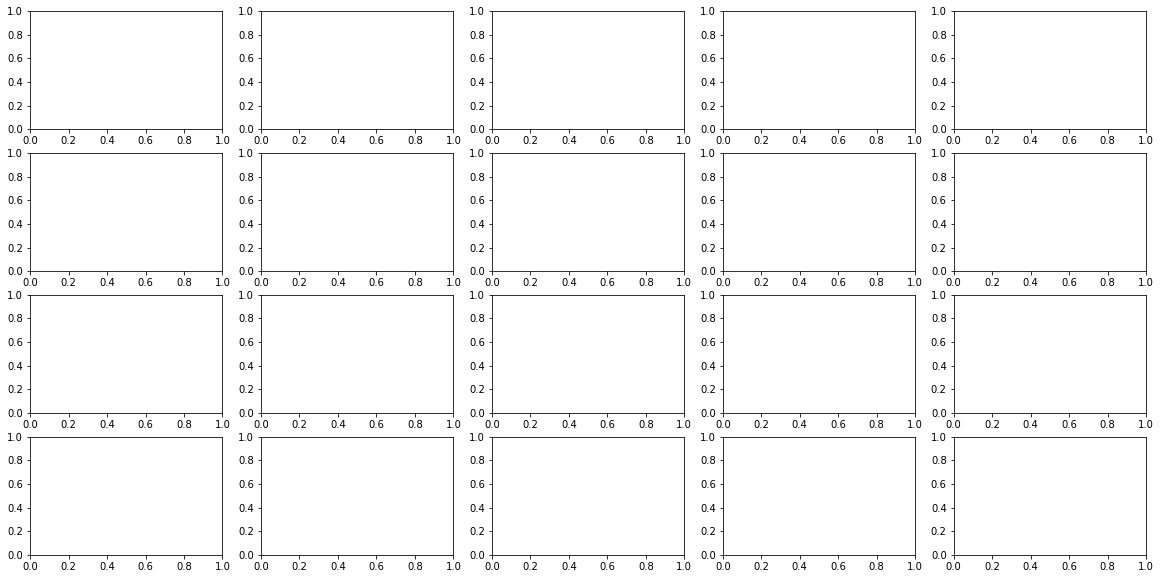

In [191]:
# 히스토그램 그리기
fig, axes = plt.subplots(4, 5, figsize=(20, 10))
for ax in axes:
  for i, key in enumerate(activ_results.keys()):
    for j,a in activ_results[key].items():
        ax.set_title(str(j+1) + "-layer")
        if j != 0: axes[i][j].set_yticks([], [])
        ax.hist(a.flatten(), 30, range=(0,1))
  
  plt.show()

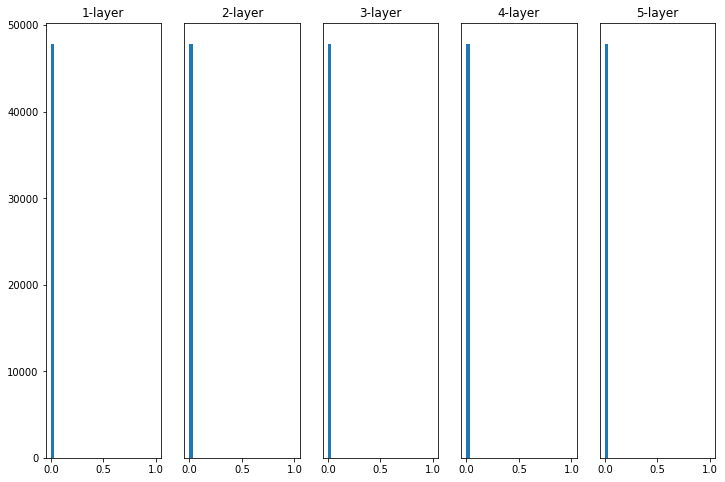

In [ ]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = weight["w2"]
    a = np.dot(x, w)


    
    z = ReLU(a)
    activations[i] = z
plt.figure(figsize=(12,8))
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

In [ ]:
dic={"dy":{"kim":3}}
dic["dy"]['kim']

3

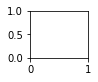

In [177]:
plt.subplot(4,5,20)